In [393]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
import pickle

In [394]:

class DataLoader:
    def __init__(self, file_path):
        self.file_path = file_path
        self.df = None

    def load_data(self):
        self.df = pd.read_csv(self.file_path)
        print("Data loaded successfully!")
        return self.df
    
    def columns(self):
        return self.df.columns
    
    def column_rename(self,old,new, place=False):
        self.df.rename(columns={old:new},inplace=place)
        print(f"Column '{old}' is renamed to '{new}'")

        
    def show_info(self):
        print("\n Dataset Info:")
        self.df.info()
        print("\n Dataset size:")
        return self.df.shape
    
    def lookup(self,method,num=0):
        if method == 'head':
            return self.df.head(num)
        elif method == 'tail':
            return self.df.tail(num)
        elif method == 'sample':
            return self.df.sample(num)
        
    def stat_info(self):
    
            print("\nSummary Stats:")
            return self.df.describe()
    
    
    def dtypes(self):
        return self.df.dtypes
    

In [395]:
class DataProcessor(DataLoader):
    def __init__(self, file_path):
        super().__init__(file_path)


    def duplicate(self, place=False):
        print("Dropping Duplicates:")
        return self.df.drop_duplicates(inplace=place)

    def check_null(self):
        return self.df.isnull().sum()

    def check_zero(self, cols):
        print("\nChecking Zero Values:")
        for col in cols:
            zero_count = (self.df[col] == 0).sum()
            print(f"{col}: {zero_count} zero values")

    def table_with_null(self, col):
        return self.df[self.df[col].isnull()]

    def table_with_zero(self, col):
        return self.df[self.df[col] == 0]

    def replace_zero_to_null(self, col):
        self.df[col] = self.df[col].replace(0, np.nan)
        print(f"Zeros are replaced with null value for column {col}")

    def fill_null(self, column, method='median'):
        if method == 'median':
            value = self.df[column].median()
        elif method == 'mean':
            value = round(self.df[column].mean(),2)
        elif method == 'mode':
            value = self.df[column].mode()[0]
        else:
            print("Method must be 'mean', 'median', or 'mode'")
            return
        self.df[column] = self.df[column].fillna(value)
        print(f"Filled missing values in '{column}' using {method}: {value}")


    def univariate_plot(self, column, chart_type='bar', color='skyblue', title=None, xlabel=None, ylabel=None):
        plt.figure(figsize=(8, 5))
        if chart_type == 'bar':
            self.df[column].value_counts().plot(kind='bar', color=color)

        elif chart_type == 'histogram':
            plt.hist(self.df[column], bins=20, color=color)

        elif chart_type == 'box':
            sns.boxplot(y=self.df[column], color=color)

        else:
            print("Invalid chart type for univariate plot.")
            return
        
        plt.title(title or f"{chart_type.capitalize()} of {column}")
        plt.xlabel(xlabel or "")
        plt.ylabel(ylabel or "")
        plt.tight_layout()
        plt.show()

    
    def bivariate_plot(self, column, target, chart_type='histplot', color='Set2', title=None, bins=20):
        if chart_type == 'histplot':
            plt.figure(figsize=(8, 5))
            sns.histplot(data=self.df, x=column, hue=target, bins=bins, palette=color, multiple='stack')
            plt.title(title or f"Histogram of {column} by {target}")
            plt.xlabel(column)
            plt.ylabel("Count")
            plt.tight_layout()
            plt.show()

        elif chart_type == 'displot':
            sns.displot(
                data=self.df,
                x=column,
                hue=target,
                kind='hist',       # Can also use 'kde'
                multiple='stack',  # or 'dodge', 'layer'
                bins=bins,
                palette=color,
                height=5,
                aspect=1.5
            )
            plt.title(title or f"Displot of {column} by {target}")
            plt.tight_layout()
            plt.show()
            
        else:
            print("Invalid chart type. Use 'histplot' or 'displot'.")


    def correlation_heatmap(self):
        plt.figure(figsize=(10, 6))
        sns.heatmap(self.df.corr(), annot=True, cmap='coolwarm', fmt=".2f", square=True)
        plt.title("Correlation Heatmap")
        plt.tight_layout()
        plt.show()

    def group_by(self, column):
        return self.df.groupby(column).mean()



In [396]:
class FinalModel(DataProcessor): 
    def __init__(self, file_path, target_column):
        super().__init__(file_path)
        self.target_column = target_column
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.model = None

    def split_data(self, test_size=0.2, random_state=42):
        X = self.df.drop(columns=[self.target_column])
        y = self.df[self.target_column]
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            X, y, test_size=test_size, random_state=random_state
        )
        print(f"Data split completed: {100 - test_size*100:.0f}% train / {test_size*100:.0f}% test")
        return self.X_train, self.X_test, self.y_train, self.y_test

    def train_svm(self, kernel='linear'):
        if self.X_train is None or self.y_train is None:
            print("Error: Please split data first using split_data() before training.")
            return None
        self.model = SVC(kernel=kernel)
        self.model.fit(self.X_train, self.y_train)
        print("SVM model trained successfully.")
        return self.model
    
    def evaluate_model(self):
        if self.model is None:
            print("Model is not trained yet.")
            return
        y_pred = self.model.predict(self.X_test)
        acc = accuracy_score(self.y_test, y_pred)
        print(f"Model Accuracy: {acc * 100:.2f}%")
        return acc

    def save_model(self, filename='svm_model.pkl'):
        if self.model:
            with open(filename, 'wb') as f:
                pickle.dump(self.model, f)
            print(f"Model saved to '{filename}'")
        else:
            print("No model found. Train the model first before saving.")


In [397]:
file_path = 'diabetes.csv'
target_column = 'Outcome'

model = FinalModel(file_path, target_column)
model.load_data()


Data loaded successfully!


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [398]:
model.show_info()


 Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB

 Dataset size:


(768, 9)

In [399]:
model.columns()


Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

In [400]:
model.column_rename('BMI', 'BodyMassIndex', place=True)
model.columns()

Column 'BMI' is renamed to 'BodyMassIndex'


Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BodyMassIndex', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

In [401]:
model.lookup('head', 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BodyMassIndex,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
5,5,116,74,0,0,25.6,0.201,30,0
6,3,78,50,32,88,31.0,0.248,26,1
7,10,115,0,0,0,35.3,0.134,29,0
8,2,197,70,45,543,30.5,0.158,53,1


In [402]:
model.lookup('sample', 12)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BodyMassIndex,DiabetesPedigreeFunction,Age,Outcome
264,4,123,62,0,0,32.0,0.226,35,1
247,0,165,90,33,680,52.3,0.427,23,0
82,7,83,78,26,71,29.3,0.767,36,0
749,6,162,62,0,0,24.3,0.178,50,1
14,5,166,72,19,175,25.8,0.587,51,1
240,1,91,64,24,0,29.2,0.192,21,0
501,3,84,72,32,0,37.2,0.267,28,0
581,6,109,60,27,0,25.0,0.206,27,0
226,0,101,76,0,0,35.7,0.198,26,0
530,2,122,60,18,106,29.8,0.717,22,0


In [403]:
model.lookup('tail',8)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BodyMassIndex,DiabetesPedigreeFunction,Age,Outcome
760,2,88,58,26,16,28.4,0.766,22,0
761,9,170,74,31,0,44.0,0.403,43,1
762,9,89,62,0,0,22.5,0.142,33,0
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1
767,1,93,70,31,0,30.4,0.315,23,0


In [404]:
model.df.shape

(768, 9)

In [405]:
model.stat_info()



Summary Stats:


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BodyMassIndex,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [406]:
model.dtypes()


Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BodyMassIndex               float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object

In [407]:
model.duplicate()


Dropping Duplicates:


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BodyMassIndex,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [408]:
model.check_null()


Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BodyMassIndex               0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [409]:
cols = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin','BodyMassIndex', 'DiabetesPedigreeFunction', 'Age', 'Outcome']

In [410]:
final_cols = ['Glucose','BloodPressure','SkinThickness','Insulin','BodyMassIndex',]

In [411]:
model.check_zero(cols)


Checking Zero Values:
Pregnancies: 111 zero values
Glucose: 5 zero values
BloodPressure: 35 zero values
SkinThickness: 227 zero values
Insulin: 374 zero values
BodyMassIndex: 11 zero values
DiabetesPedigreeFunction: 0 zero values
Age: 0 zero values
Outcome: 500 zero values


In [412]:
model.check_zero(final_cols)


Checking Zero Values:
Glucose: 5 zero values
BloodPressure: 35 zero values
SkinThickness: 227 zero values
Insulin: 374 zero values
BodyMassIndex: 11 zero values


In [413]:
model.table_with_zero('BloodPressure')

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BodyMassIndex,DiabetesPedigreeFunction,Age,Outcome
7,10,115,0,0,0,35.3,0.134,29,0
15,7,100,0,0,0,30.0,0.484,32,1
49,7,105,0,0,0,0.0,0.305,24,0
60,2,84,0,0,0,0.0,0.304,21,0
78,0,131,0,0,0,43.2,0.270,26,1
81,2,74,0,0,0,0.0,0.102,22,0
172,2,87,0,23,0,28.9,0.773,25,0
193,11,135,0,0,0,52.3,0.578,40,1
222,7,119,0,0,0,25.2,0.209,37,0
261,3,141,0,0,0,30.0,0.761,27,1


In [414]:
model.table_with_zero('Glucose')


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BodyMassIndex,DiabetesPedigreeFunction,Age,Outcome
75,1,0,48,20,0,24.7,0.140,22,0
182,1,0,74,20,23,27.7,0.299,21,0
342,1,0,68,35,0,32.0,0.389,22,0
349,5,0,80,32,0,41.0,0.346,37,1
502,6,0,68,41,0,39.0,0.727,41,1


In [415]:
model.table_with_null('Glucose')


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BodyMassIndex,DiabetesPedigreeFunction,Age,Outcome


In [416]:
for col in final_cols:
    model.replace_zero_to_null(col)

Zeros are replaced with null value for column Glucose
Zeros are replaced with null value for column BloodPressure
Zeros are replaced with null value for column SkinThickness
Zeros are replaced with null value for column Insulin
Zeros are replaced with null value for column BodyMassIndex


In [417]:
model.check_null()

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BodyMassIndex                11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

In [418]:
model.table_with_null('Glucose')

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BodyMassIndex,DiabetesPedigreeFunction,Age,Outcome
75,1,NaN,48.0,20.0,NaN,24.7,0.140,22,0
182,1,NaN,74.0,20.0,23.0,27.7,0.299,21,0
342,1,NaN,68.0,35.0,NaN,32.0,0.389,22,0
349,5,NaN,80.0,32.0,NaN,41.0,0.346,37,1
502,6,NaN,68.0,41.0,NaN,39.0,0.727,41,1


In [419]:
model.fill_null('Glucose', method='mode')

Filled missing values in 'Glucose' using mode: 99.0


In [420]:
model.fill_null('BloodPressure', method='median')


Filled missing values in 'BloodPressure' using median: 72.0


In [421]:
model.fill_null('SkinThickness', method='mode')


Filled missing values in 'SkinThickness' using mode: 32.0


In [422]:
model.fill_null('Insulin', method='mean')


Filled missing values in 'Insulin' using mean: 155.55


In [423]:
model.fill_null('BodyMassIndex', method='mean')


Filled missing values in 'BodyMassIndex' using mean: 32.46


In [424]:
model.check_null()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BodyMassIndex               0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [425]:
model.check_zero(final_cols)


Checking Zero Values:
Glucose: 0 zero values
BloodPressure: 0 zero values
SkinThickness: 0 zero values
Insulin: 0 zero values
BodyMassIndex: 0 zero values


In [426]:
model.lookup('sample' , 9)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BodyMassIndex,DiabetesPedigreeFunction,Age,Outcome
483,0,84.0,82.0,31.0,125.00,38.2,0.233,23,0
326,1,122.0,64.0,32.0,156.00,35.1,0.692,30,1
609,1,111.0,62.0,13.0,182.00,24.0,0.138,23,0
470,1,144.0,82.0,40.0,155.55,41.3,0.607,28,0
753,0,181.0,88.0,44.0,510.00,43.3,0.222,26,1
512,9,91.0,68.0,32.0,155.55,24.2,0.200,58,0
578,10,133.0,68.0,32.0,155.55,27.0,0.245,36,0
347,3,116.0,72.0,32.0,155.55,23.5,0.187,23,0
5,5,116.0,74.0,32.0,155.55,25.6,0.201,30,0


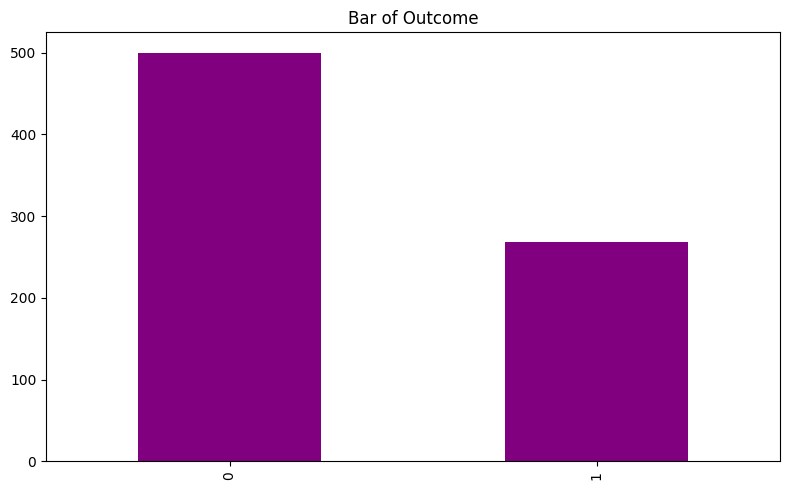

In [427]:
model.univariate_plot(target_column, chart_type='bar', color='purple')


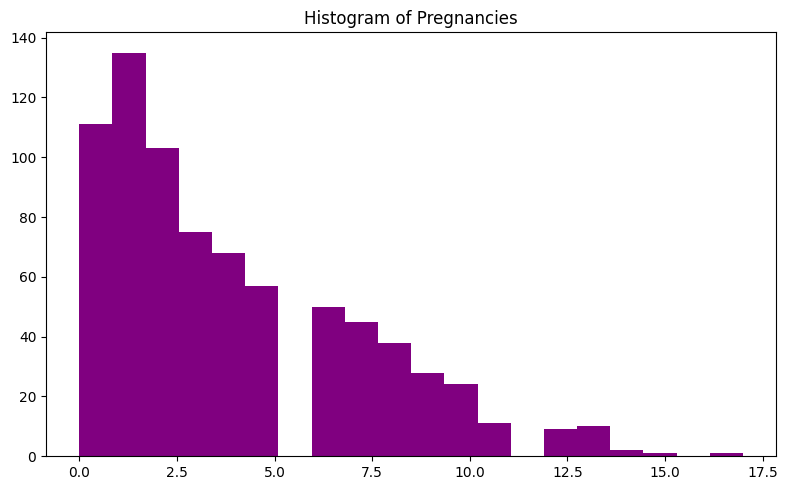

In [428]:

model.univariate_plot('Pregnancies', chart_type='histogram',color='purple')


In [429]:
model.columns()

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BodyMassIndex', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

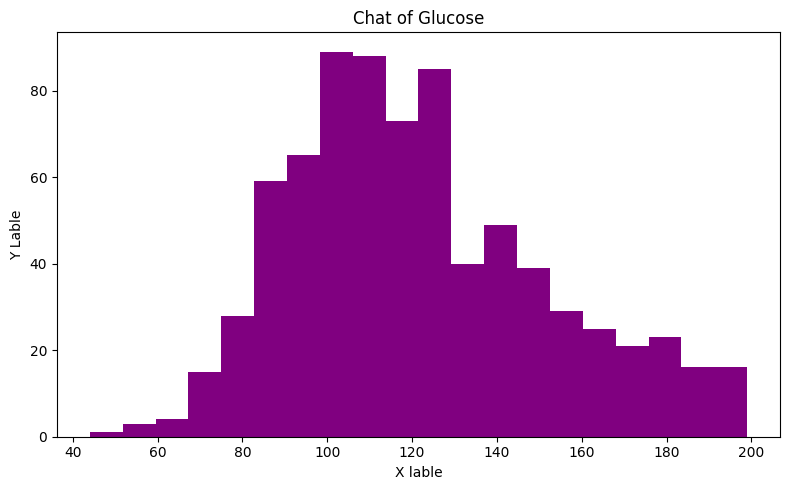

In [430]:
# bar , pie , histogram , box 

model.univariate_plot('Glucose','histogram','purple','Chat of Glucose','X lable','Y Lable',)

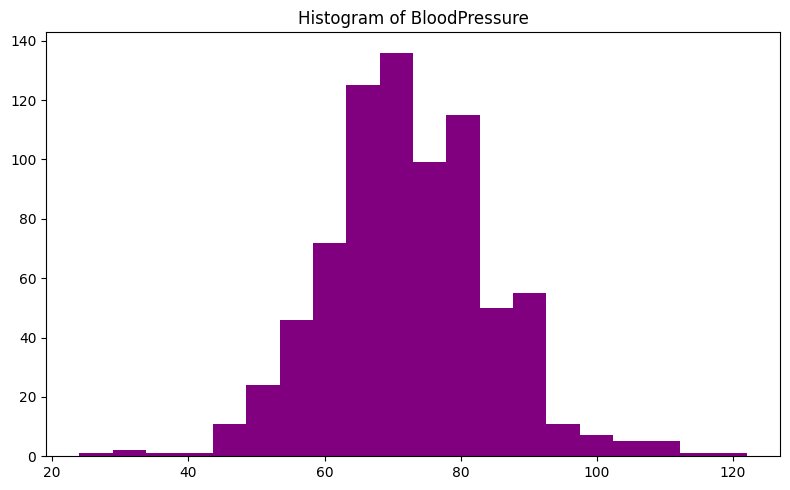

In [431]:
model.univariate_plot('BloodPressure','histogram','purple',)


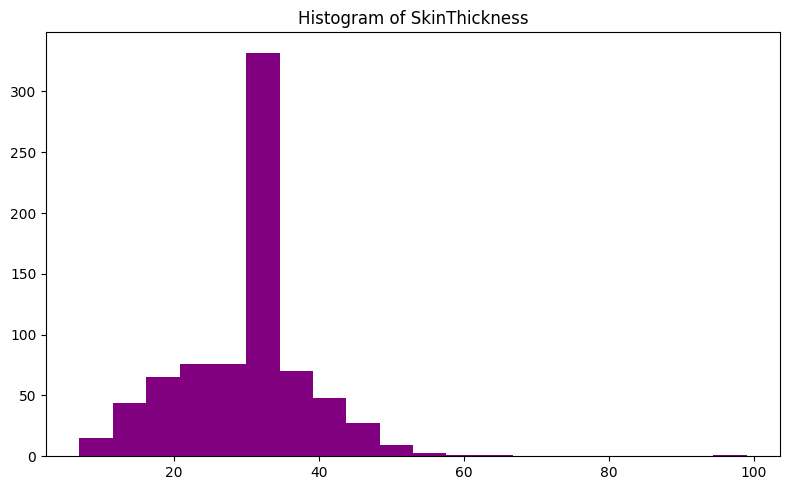

In [432]:
model.univariate_plot('SkinThickness','histogram','purple')


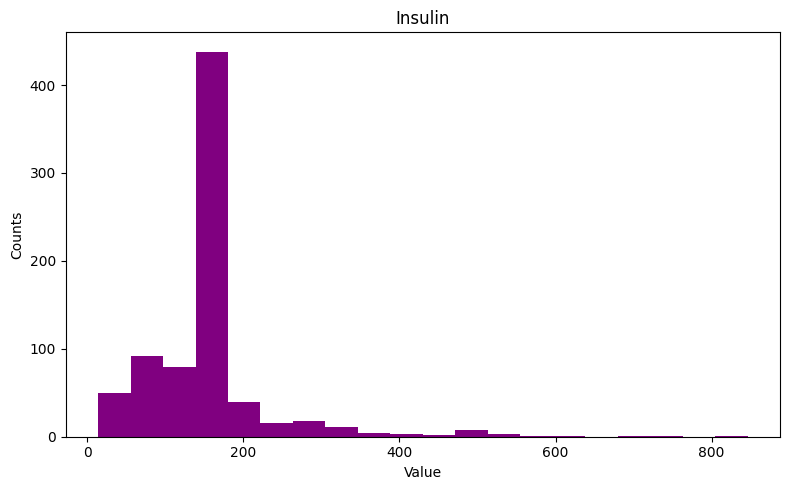

In [433]:
model.univariate_plot('Insulin',chart_type='histogram',color='purple',title='Insulin',xlabel='Value',ylabel='Counts')


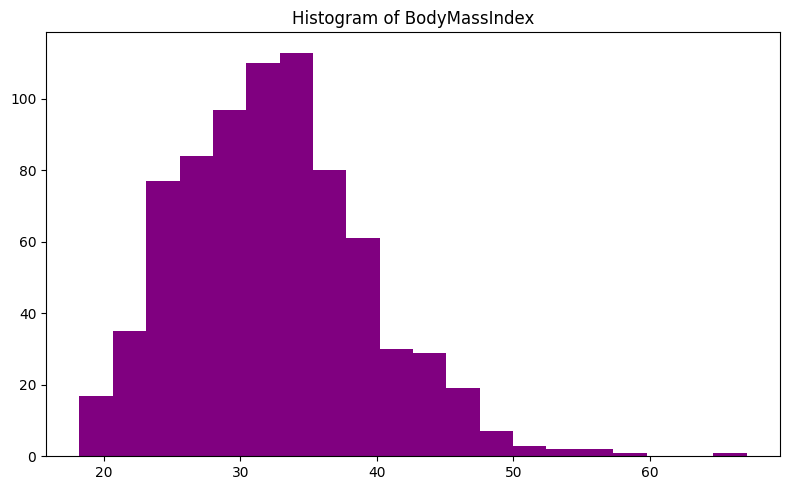

In [434]:
model.univariate_plot('BodyMassIndex','histogram','purple')


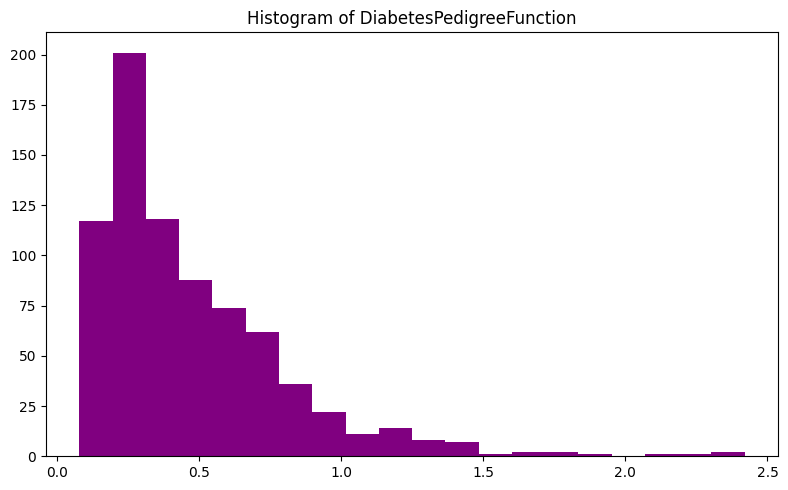

In [435]:
model.univariate_plot('DiabetesPedigreeFunction','histogram','purple')


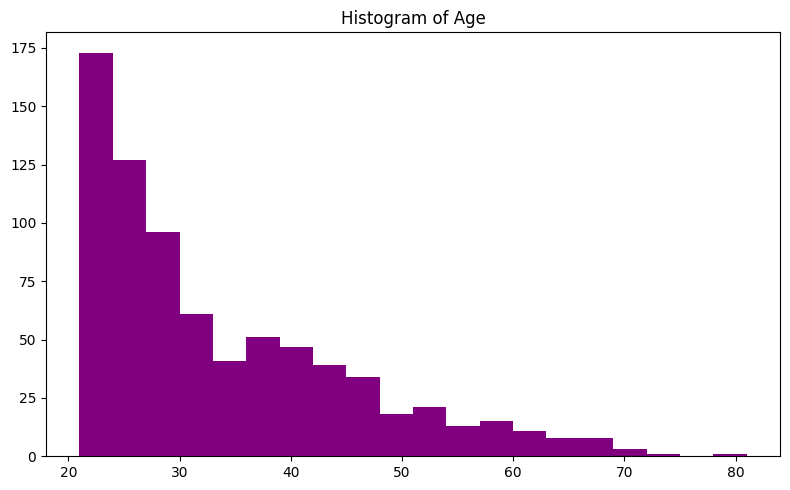

In [436]:
model.univariate_plot('Age','histogram','purple')


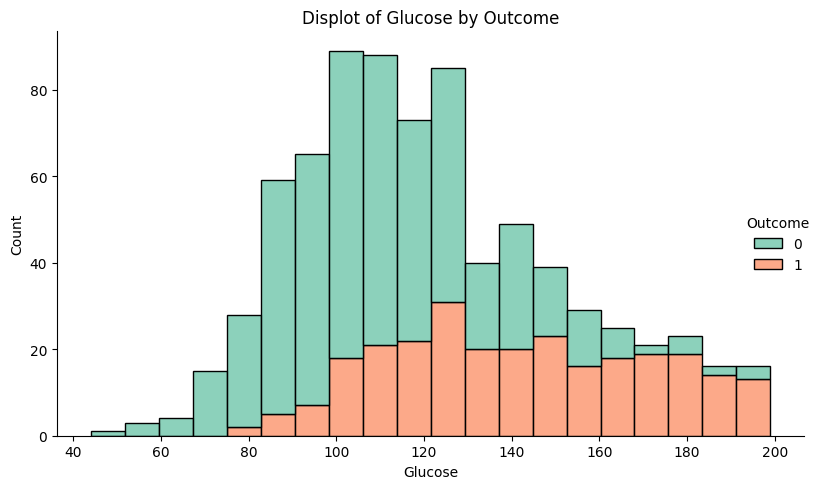

In [437]:
model.bivariate_plot('Glucose', target_column, chart_type='displot')
# Invalid chart type. Use 'histplot' or 'displot'.

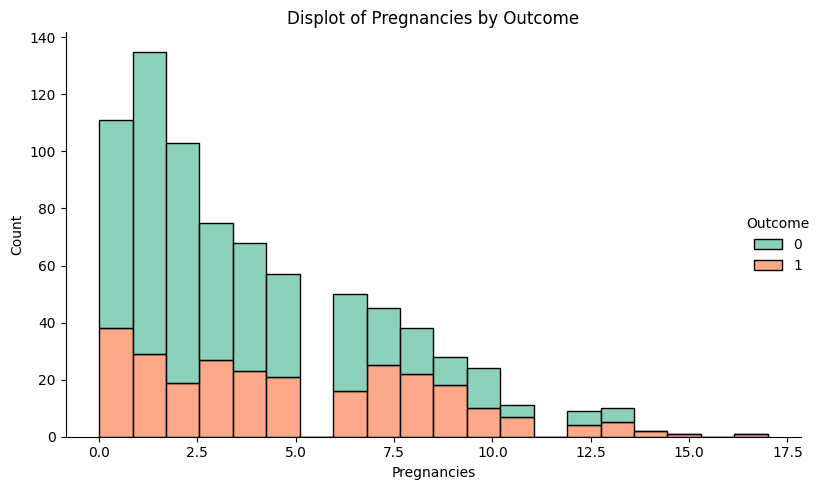

In [438]:
model.bivariate_plot('Pregnancies', target_column, chart_type='displot')


In [439]:
model.columns()

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BodyMassIndex', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

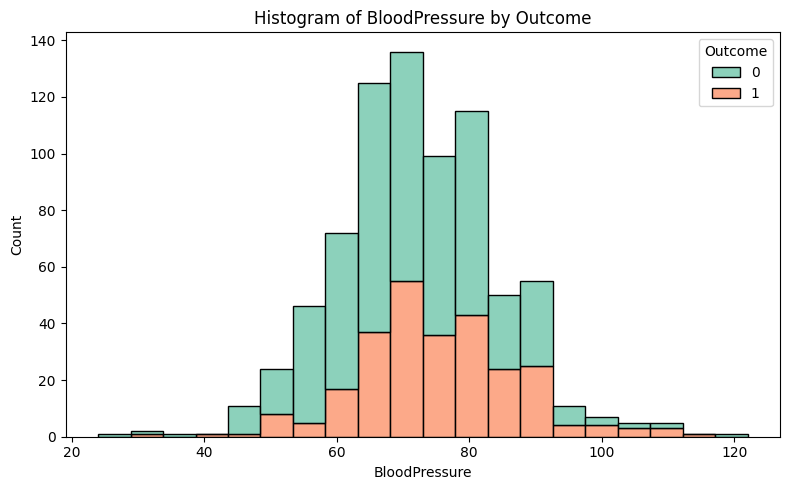

In [440]:
model.bivariate_plot('BloodPressure', target_column, chart_type='histplot')


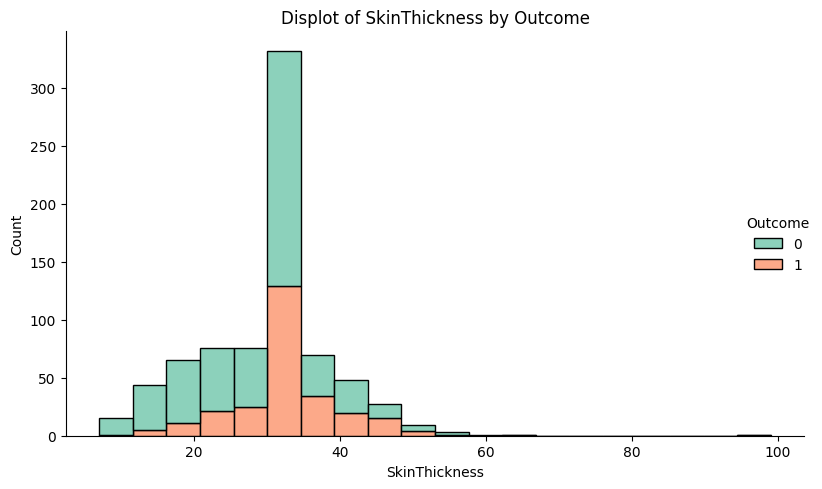

In [441]:
model.bivariate_plot('SkinThickness', target_column, chart_type='displot',color='Set2')


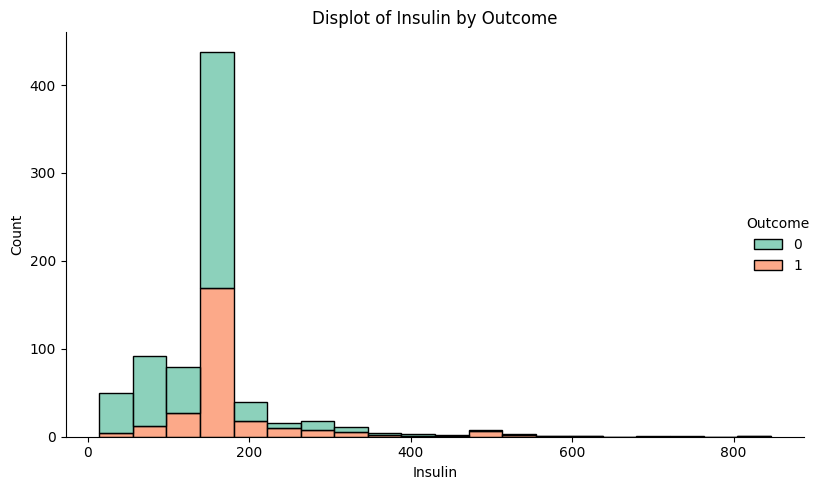

In [442]:
model.bivariate_plot('Insulin', target_column, chart_type='displot')


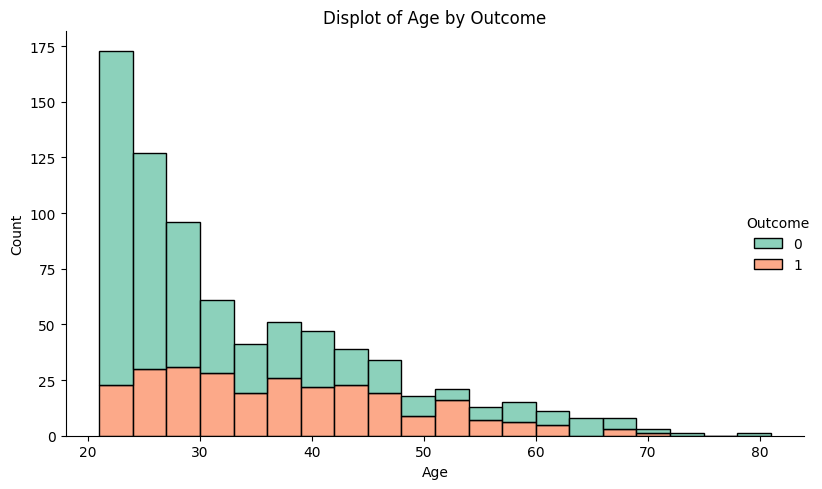

In [443]:
model.bivariate_plot('Age', target_column, chart_type='displot')


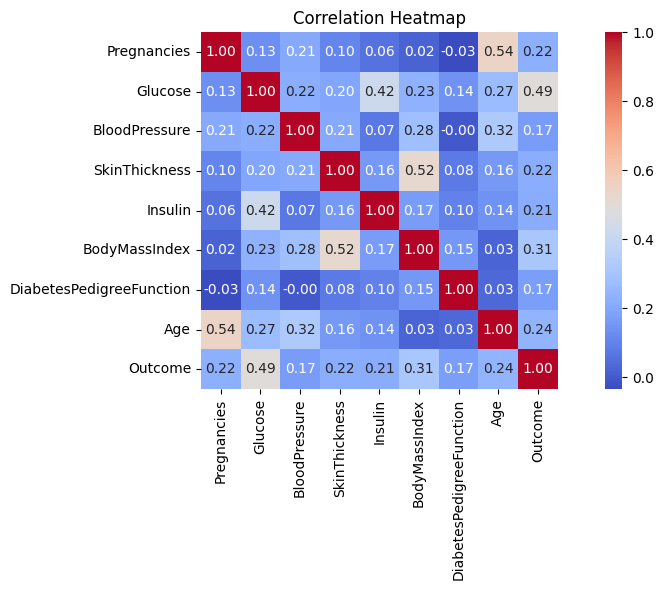

In [444]:
model.correlation_heatmap()


In [445]:
model.group_by(target_column)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BodyMassIndex,DiabetesPedigreeFunction,Age
Outcome,,,,,,,,
0,3.298000,110.574000,70.920000,28.560000,142.211600,30.888480,0.429734,31.190000
1,4.865672,141.996269,75.123134,32.671642,180.432463,35.384776,0.550500,37.067164


In [446]:
_ = model.split_data(test_size=0.3, random_state=42)


Data split completed: 70% train / 30% test


In [447]:
_ = model.train_svm(kernel='linear')


SVM model trained successfully.


In [448]:
model.evaluate_model()

Model Accuracy: 73.59%


0.7359307359307359

In [449]:
model.save_model('svm_model.pkl')


Model saved to 'svm_model.pkl'
